# Automatic peak finding and calibration tools in Becquerel

`Becquerel` contains tools for obtaining a rough first calibration for an uncalibrated `Spectrum`.

First, some imports:

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import becquerel as bq

%matplotlib inline

Also some function definitions:

In [2]:
def plot_spec(spectrum, xmode="channel"):
    if xmode == "channel":
        facecolor = "green"
    else:
        facecolor = "blue"
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot("k-", lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == "channel":
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title("Uncalibrated spectrum")
    else:
        plt.xlim(0, spectrum.bin_centers_kev[-1])
        plt.title("Calibrated spectrum")
    plt.yscale("log")
    plt.ylim(2e-1)
    plt.tight_layout()


def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print("fit gain:", cal.gain, "keV/channel")
    print("fit channels:", cal.fit_channels)

    plt.figure()
    plt.title("Peaks used in fit")
    cal.plot()
    plt.tight_layout()

    plot_spec(cal.peakfinder.spectrum, xmode="channel")
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan - 10 : chan + 10].max() * 1.5
        plt.plot([x, x], [1e-1, y], "r-", alpha=0.5)
        plt.text(x, y, f"{erg:.1f} keV")

    plot_spec(cal.peakfinder.spectrum, xmode="energy")
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan - 15 : chan + 15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], "r-", alpha=0.5)
        plt.text(erg, y, f"{erg:.1f} keV")

## `PeakFilter` classes

Instances of `PeakFilter` classes generate energy-dependent kernels that can be convolved with a spectrum to extract lines from the background continuum. To instantiate a kernel, the FWHM in channels at a specific channel is required, and the kernel scales the FWHM so that it is proportional to the square root of the channel (approximating the energy resolution of a detector).

Here is what a `GaussianDerivPeakFilter` looks like:

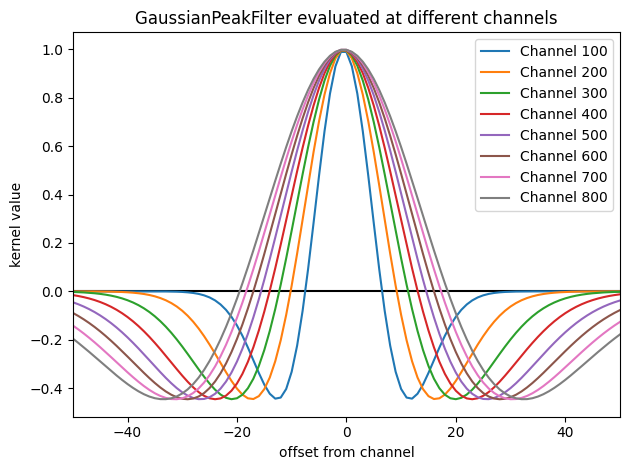

In [3]:
# demonstrate energy-dependent kernels
channels = np.arange(1000)
for kernel in [bq.GaussianPeakFilter(1000, 50, 5)]:
    plt.figure()
    plt.title(f"{type(kernel).__name__} evaluated at different channels")
    ind = np.arange(1000)

    plt.plot([-50, 50], [0, 0], "k-")
    for chan in range(100, 900, 100):
        kern = kernel.kernel(chan, np.arange(1001))
        plt.plot(ind - chan, kern, "-", lw=1.5, label=f"Channel {chan}")
    plt.xlim(-50, 50)
    plt.xlabel("offset from channel")
    plt.ylabel("kernel value")
    plt.legend()
    plt.tight_layout()

We will use the `GaussiaPeakKernel` from now on.

A kernel can create a matrix that can be multiplied with a spectrum to perform the convolution. Here is what such a matrix could look like:

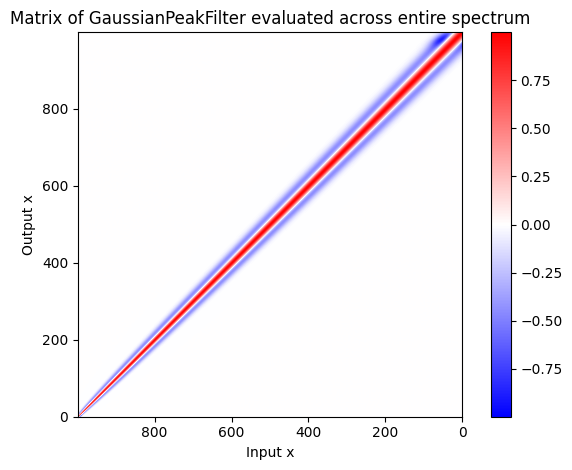

In [4]:
# display the kernel matrix
kernel = bq.GaussianPeakFilter(1000, 50, 5)

plt.figure()
plt.title("Matrix of GaussianPeakFilter evaluated across entire spectrum")
kernel.plot_matrix(np.arange(1000))
plt.tight_layout()

## `PeakFinder` and `AutoCalibrator` classes

The `PeakFinder` class allows one to automatically select peaks that a `PeakFilter` filters out of the spectrum.

The `AutoCalibrator` class takes the peaks found by a `PeakFinder` and finds the most likely energies associated with those peaks.

It is easiest to explain these classes using examples.

## Example 1: Calibrating a scintillator spectrum

First we read in a raw spectrum from file (this is a simulated background spectrum for a scintillator):

SpeFile: Reading file becquerel/../tests/samples/sim_spec.spe


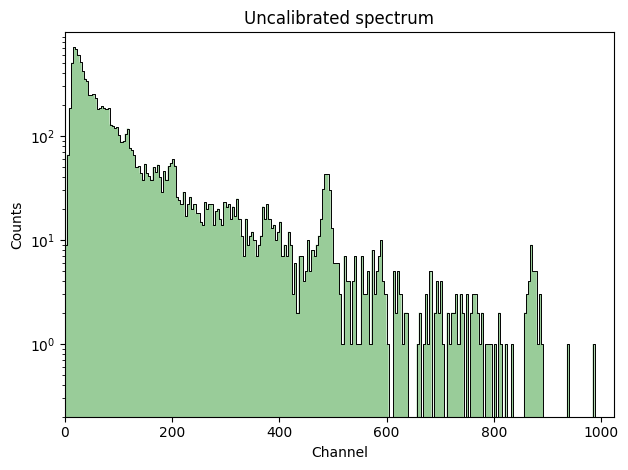

In [5]:
counts = []
filename = Path(bq.__file__).parent / "../tests/samples/sim_spec.spe"
spec = bq.Spectrum.from_file(filename)
spec = spec.combine_bins(4)
spec.bin_edges_raw *= 4
plot_spec(spec)

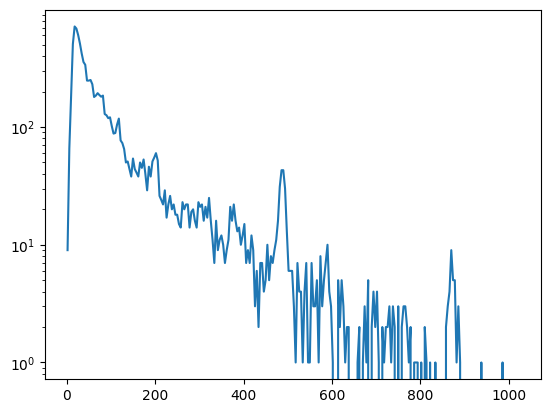

In [6]:
plt.figure()
plt.plot(spec.bin_centers_raw, spec.counts_vals)
plt.yscale("log")
plt.show()

To filter this spectrum we will use a kernel with a width of 50 channels at 500 channels, to match the strong line in the center (most likely the K-40 line at 1460 keV):

In [7]:
kernel = bq.GaussianPeakFilter(500, 50, fwhm_at_0=10)

### 1.1 `PeakFinder` class

The `PeakFinder` class uses a `PeakFilter` to filter and calibrate the spectrum.

Under the hood, the kernel estimates the SNR of each peak by separating peaks from the background continuum. We can introspect this process using the `PeakFinder` instance:

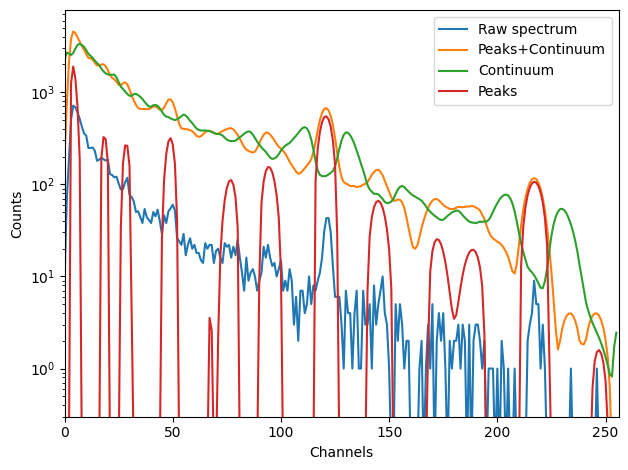

In [8]:
# show how the kernel estimates the peaks+background and the background
finder = bq.PeakFinder(spec, kernel)

plt.figure()
plt.plot(spec.counts_vals.clip(1e-1), label="Raw spectrum")
plt.plot(finder._peak_plus_bkg.clip(1e-1), label="Peaks+Continuum")
plt.plot(finder._bkg.clip(1e-1), label="Continuum")
plt.plot(finder._signal.clip(1e-1), label="Peaks")
plt.yscale("log")
plt.xlim(0, len(spec))
plt.ylim(3e-1)
plt.xlabel("Channels")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()

The kernel applied directly to the spectral count data produces the estimated signal-to-noise (SNR) of each peak.

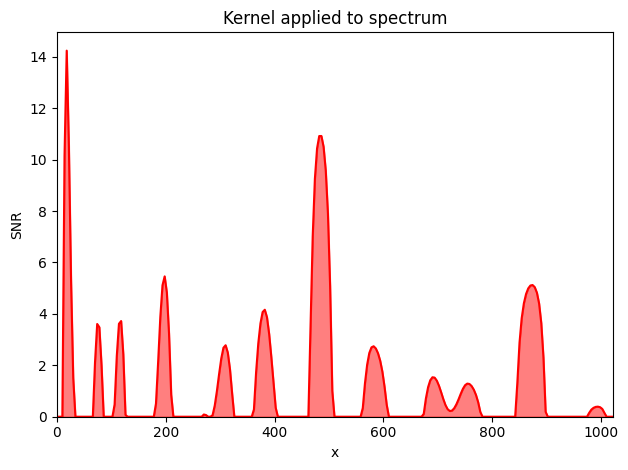

In [9]:
# plot signal to noise
plt.figure()
plt.title("Kernel applied to spectrum")
finder.plot()
plt.tight_layout()

### 1.2 Using `find_peak` to find a specific peak

Use the method `find_peak` to find a specific peak in the spectrum.

Let's try to locate the index of the tallest peak, right in the middle of the spectrum:

486.0


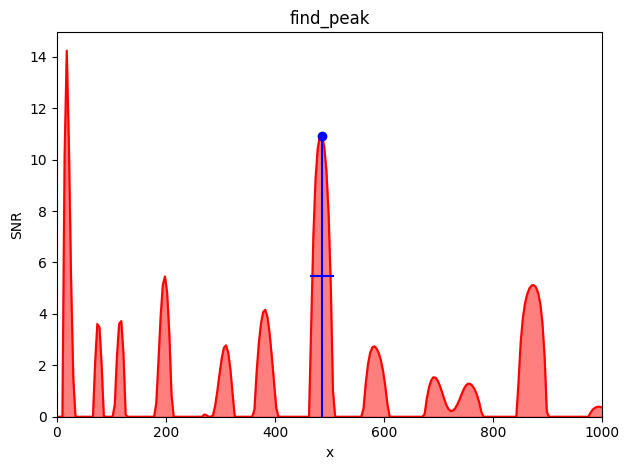

In [10]:
peak_chan = finder.find_peak(500, min_snr=3.0)
print(peak_chan)

plt.figure()
plt.title("find_peak")
finder.plot()
plt.xlim(0, 1000)
plt.tight_layout()

In [11]:
finder.centroids

[np.float64(486.0)]

Subsequent calls to `find_peak` will store the any new results:

874.0


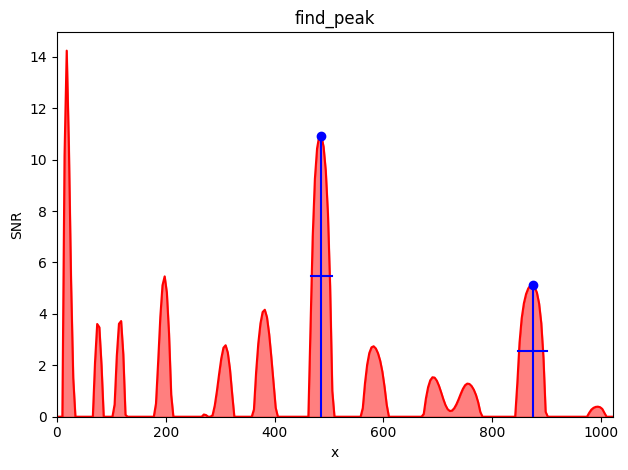

In [12]:
peak_chan = finder.find_peak(900, min_snr=3.0)
print(peak_chan)

plt.figure()
plt.title("find_peak")
finder.plot()
plt.tight_layout()

#### 1.2 Use `reset` to remove all candidate peaks and calibration data

The list of candidate peaks will persist in the `PeakFinder` object, as will any calibration information (will be covered later).

Resetting the current object yields:

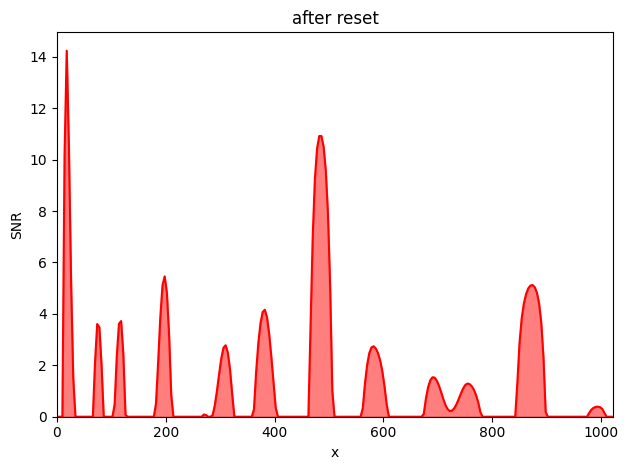

In [13]:
finder.reset()

plt.figure()
plt.title("after reset")
finder.plot()
plt.tight_layout()

### 1.2 Using `find_peaks` to find all peaks above an SNR threshold

Instead of repeatedly calling `find_peak`, one can build up a set of peak candidates using `find_peaks`. The following locates all peaks above channel 50 and an SNR of 2:

[np.float64(74.0), np.float64(118.0), np.float64(198.0), np.float64(310.0), np.float64(382.0), np.float64(486.0), np.float64(582.0), np.float64(754.0), np.float64(874.0)]
[np.float64(3.6075673089707934), np.float64(3.721276256701769), np.float64(5.459959653334882), np.float64(2.7800349225433174), np.float64(4.161224036237381), np.float64(10.919027007724871), np.float64(2.7411225967995594), np.float64(1.288723108583641), np.float64(5.122641397628744)]


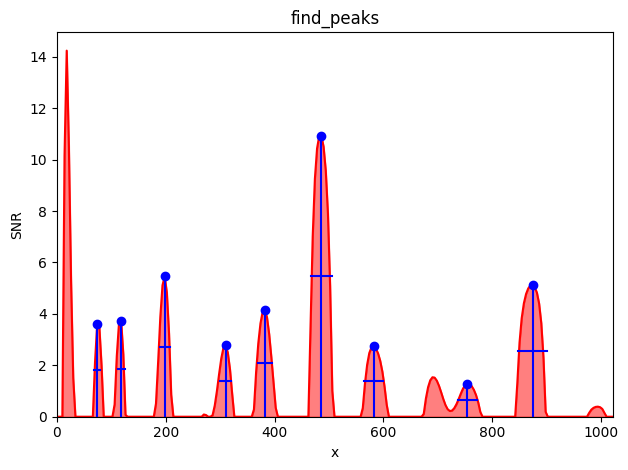

In [14]:
finder.find_peaks(min_snr=1, xmin=50)
print(finder.centroids)
print(finder.snrs)

plt.figure()
plt.title("find_peaks")
finder.plot()
plt.tight_layout()

### 1.4 The `AutoCalibrator.fit` method

The main machinery of auto-calibration is the `fit` method, which matches peak candidates (e.g., the outputs of `find_peaks`) with specific line energies and keeps the best match:

found best gain: 3.007556 keV/channel
fit gain: 3.0075562133221196 keV/channel
fit channels: [118. 198. 486. 582. 874.]


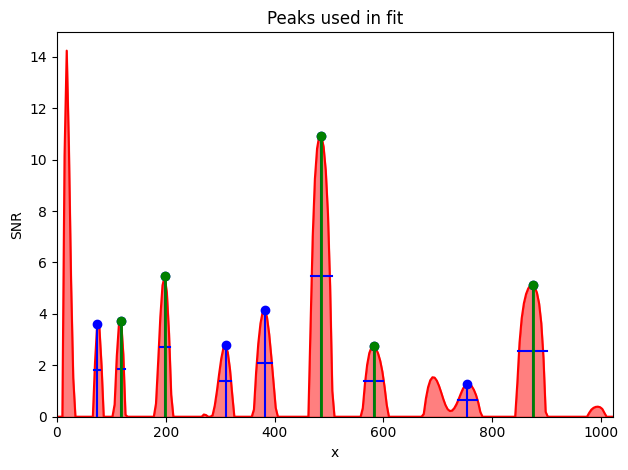

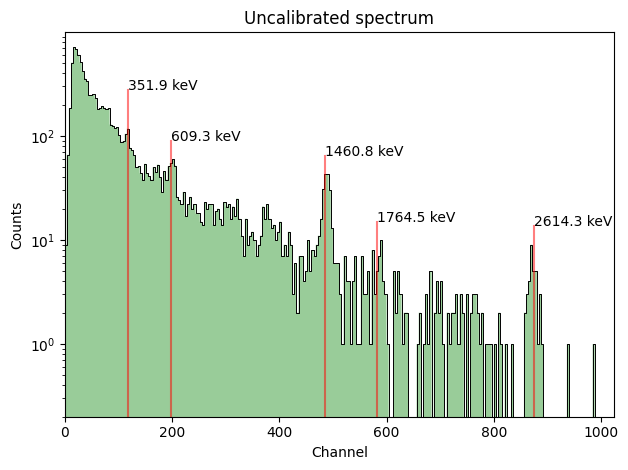

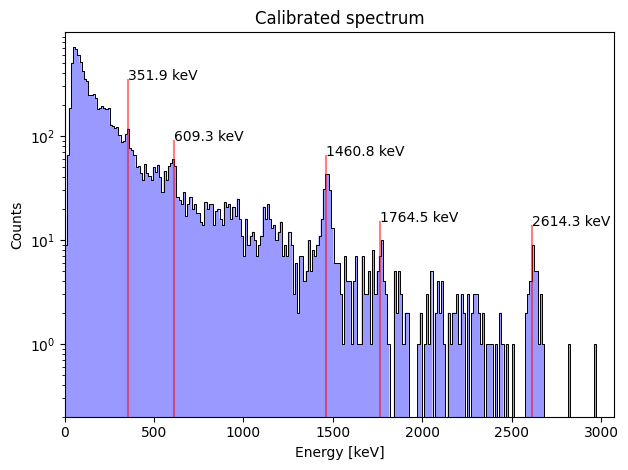

In [15]:
cal = bq.AutoCalibrator(finder)
cal.fit(
    [351.93, 609.32, 1460.82, 2614.3],
    optional=[295.22, 768.36, 1120.294, 1238.122, 1764.49],
    gain_range=[2.5e-2, 4e2],
    de_max=200.0,
)
plot_calibrator(cal)

### 1.5 `AutoCalibrator.fit` with only one peak

A special case of the calibrator is when only one peak has been found and only one energy is given. Use this with caution since there is none of the cross-validation that comes with multiple lines.

fit gain: 3.0058024691358023 keV/channel
fit channels: [np.float64(486.0)]


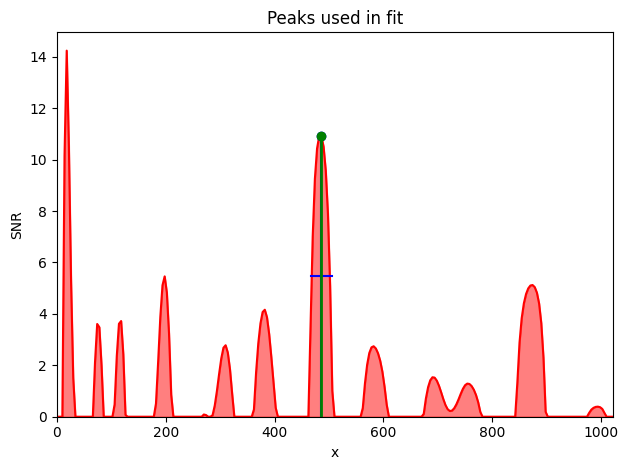

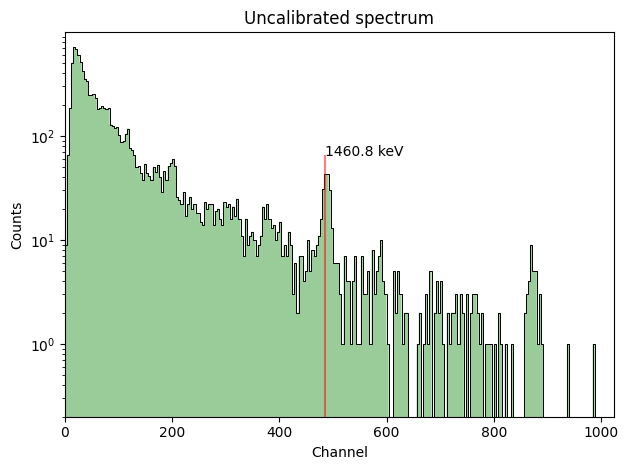

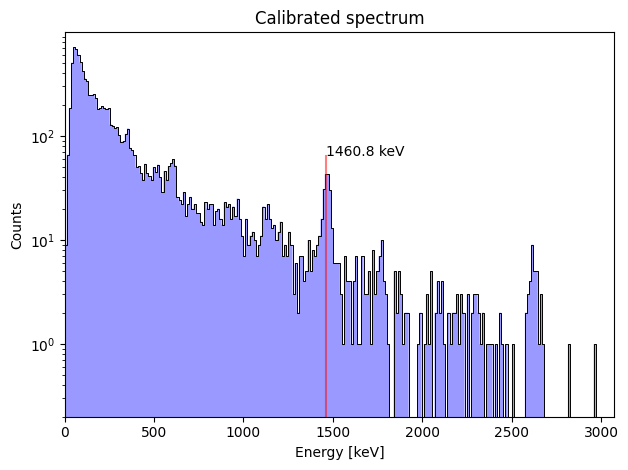

In [16]:
cal.peakfinder.reset()
cal.peakfinder.fwhm_tol = (0.5, 1.2)
cal.peakfinder.find_peak(500, min_snr=3.0)
cal.fit([1460.82], gain_range=[2.5e-1, 4e1], de_max=50.0)
plot_calibrator(cal)

In [17]:
# looks like there may be an off-by-one or bin center vs edge issue in plotting...

## Example 2: Calibrating an HPGe spectrum

Let's perform the same calibration steps using an HPGe spectrum. This spectrum will have many more lines to fit.

SpeFile: Reading file becquerel/../tests/samples/Mendocino_07-10-13_Acq-10-10-13.Spe


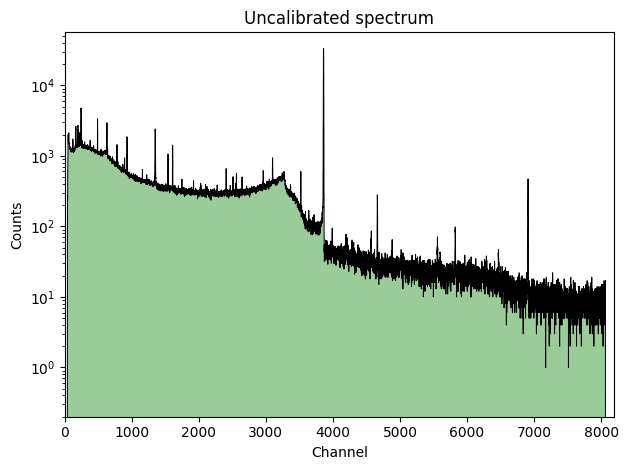

In [18]:
# read raw HPGe data
filename = (
    Path(bq.__file__).parent /
    "../tests/samples/Mendocino_07-10-13_Acq-10-10-13.Spe"
)
spec = bq.Spectrum.from_file(filename)
plot_spec(spec)

We will again use a `GaussianDerivKernel`, but this one must be much narrower to match the resolution. Not surprisingly, many of the peaks in the spectrum have higher SNR values:

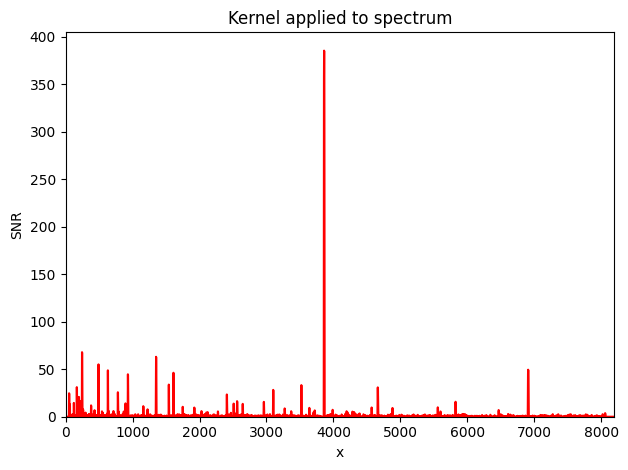

In [19]:
# apply the kernel to the data to get SNR
kernel = bq.GaussianPeakFilter(3700, 10, fwhm_at_0=5)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

plt.figure()
plt.title("Kernel applied to spectrum")
cal.peakfinder.plot()
plt.tight_layout()

[np.float64(490.5), np.float64(630.5), np.float64(779.5), np.float64(929.5), np.float64(1350.5), np.float64(1540.5), np.float64(1610.5), np.float64(2407.5), np.float64(2560.5), np.float64(2960.5), np.float64(3100.5), np.float64(3520.5), np.float64(3860.5), np.float64(4662.5), np.float64(5824.5), np.float64(6908.5)]
[np.float64(55.126803130947856), np.float64(48.8421072030614), np.float64(25.752746363250044), np.float64(44.67167209625761), np.float64(63.120214949684964), np.float64(33.82811416542263), np.float64(46.300099407690325), np.float64(23.4229687599493), np.float64(16.38273455758562), np.float64(15.655271688770286), np.float64(28.266675845645384), np.float64(33.3143255899944), np.float64(385.53504907503793), np.float64(30.878123203107357), np.float64(15.751894560701217), np.float64(49.508919129747156)]


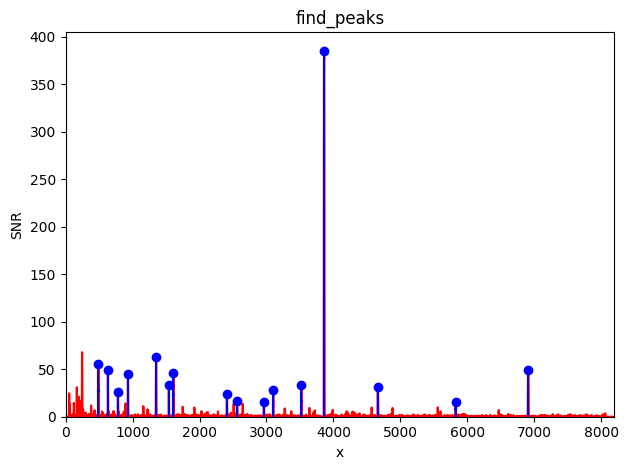

In [20]:
# find significant peaks
cal.peakfinder.find_peaks(min_snr=15, xmin=400)
print(cal.peakfinder.centroids)
print(cal.peakfinder.snrs)

plt.figure()
plt.title("find_peaks")
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.378403 keV/channel
fit gain: 0.37840313221263705 keV/channel
fit channels: [ 779.5  929.5 1350.5 1610.5 2407.5 2960.5 3860.5 4662.5 5824.5 6908.5]


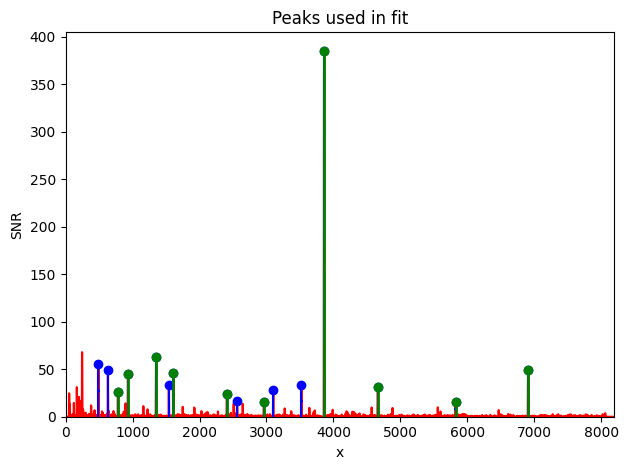

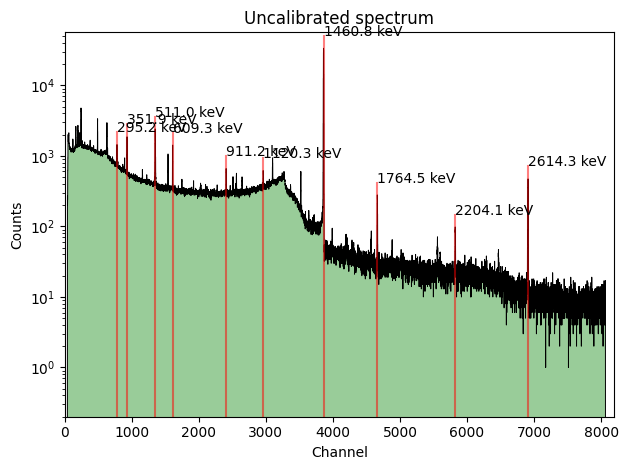

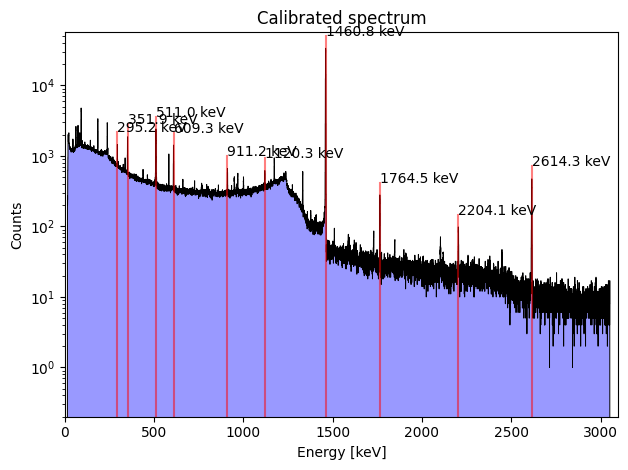

In [21]:
# perform calibration
cal.fit(
    [295.22, 351.93, 511.0, 609.32, 1460.82, 2614.3],
    optional=[583.187, 911.20, 1120.294, 1238.122, 1377.67, 1764.49, 2204.06],
    gain_range=[0.35, 0.40],
    de_max=5.0,
)
plot_calibrator(cal)

## Example 3: An unusual NaI spectrum

This example shows a real spectrum from a NaI detector with very poor energy resolution and where the dynamic range has cut off the higher energies. Can we still calibrate it?

SpeFile: Reading file becquerel/../tests/samples/nai_detector.spe


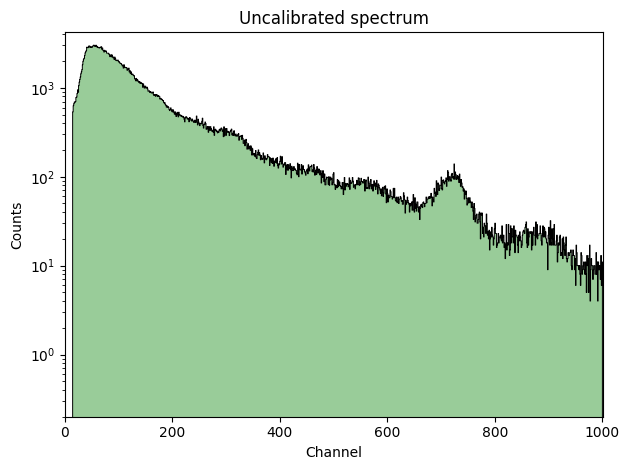

In [22]:
counts = []
filename = Path(bq.__file__).parent / "../tests/samples/nai_detector.spe"
spec = bq.Spectrum.from_file(filename)
plot_spec(spec)

[np.float64(116.5), np.float64(175.5), np.float64(248.5), np.float64(316.5), np.float64(462.5), np.float64(561.5), np.float64(721.5), np.float64(883.5)]
[np.float64(5.71891107858006), np.float64(5.492935870368166), np.float64(3.2151496377032043), np.float64(9.031072112758185), np.float64(6.0409842208259), np.float64(5.451491700614276), np.float64(26.023065298029202), np.float64(4.404461339902027)]


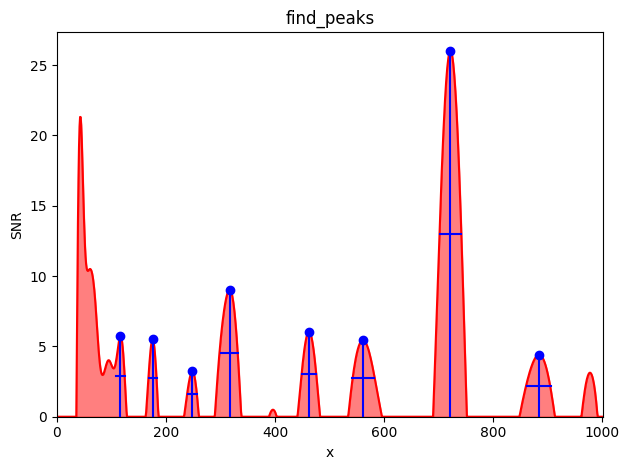

In [23]:
kernel = bq.GaussianPeakFilter(700, 50, 10)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

# find significant peaks
cal.peakfinder.find_peaks(min_snr=3, xmin=100)
print(cal.peakfinder.centroids)
print(cal.peakfinder.snrs)

plt.figure()
plt.title("find_peaks")
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 2.581675 keV/channel
fit gain: 2.5816751785910594 keV/channel
fit channels: [248.5 561.5]


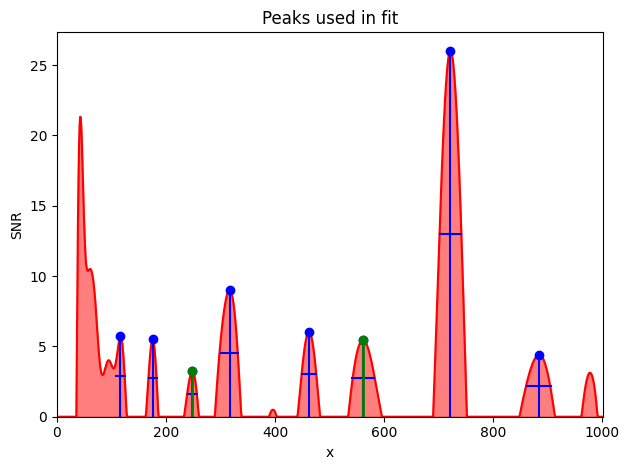

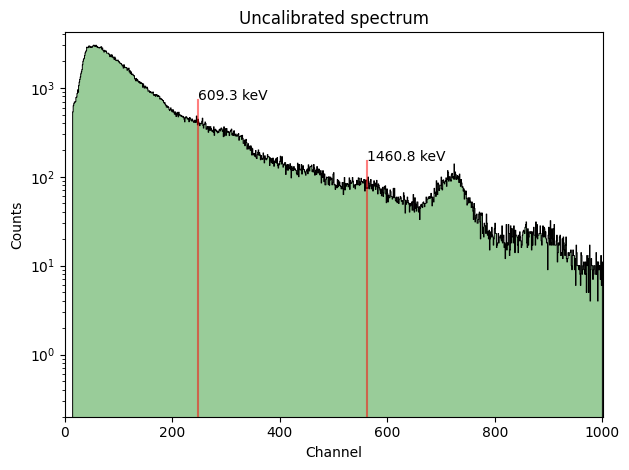

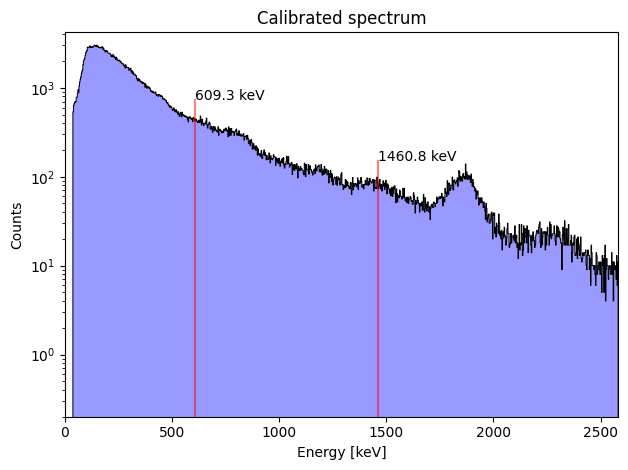

In [24]:
# perform calibration
cal.fit(
    [609.32, 1460.82],
    optional=[],
    gain_range=[0.1, 5.0],
    de_max=50.0,
)
plot_calibrator(cal)

That did not work right, the calibrator matched with the wrong lines. To fix this, we could either increase `xmin` to exclude the lower energy lines, increase `min_snr` to exclude the lower significance lines, or add optional energies. Let's try the same fit but with a longer list of prominent background lines:

found best gain: 2.016920 keV/channel
fit gain: 2.016919938989843 keV/channel
fit channels: [116.5 175.5 316.5 462.5 561.5 721.5 883.5]


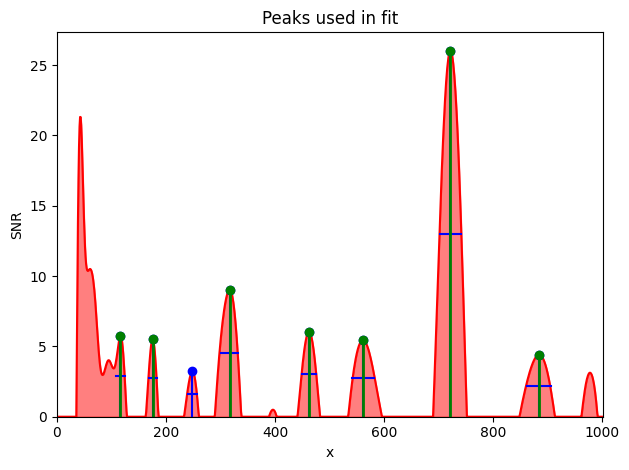

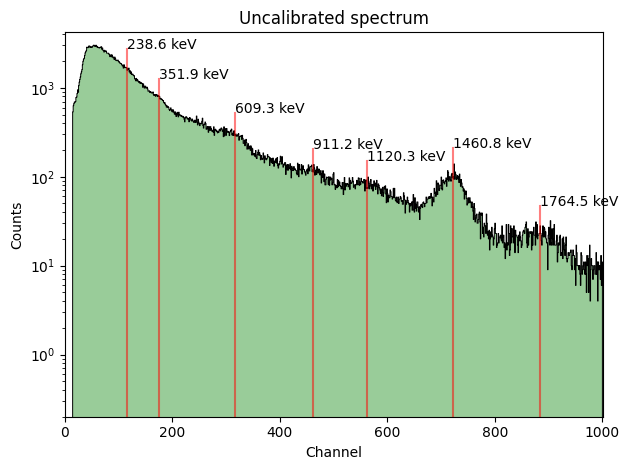

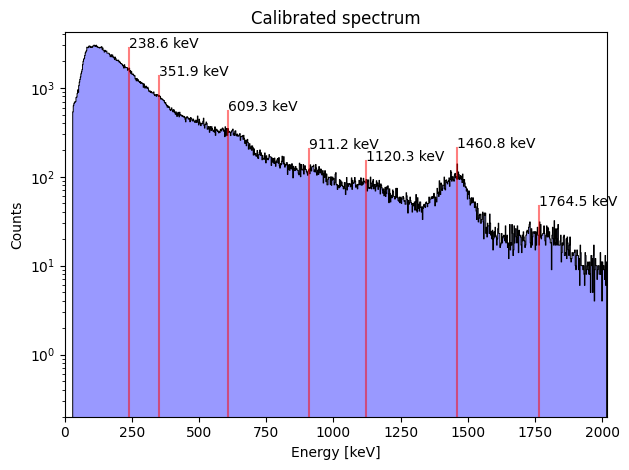

In [25]:
# perform calibration again, but with more optional energies
cal.fit(
    [609.32, 1460.82],
    optional=[238.63, 338.32, 351.93, 911.20, 1120.294, 1620.50, 1764.49, 2118.514],
    gain_range=[0.1, 5.0],
    de_max=50.0,
)
plot_calibrator(cal)

Success! The cross-validation used in `AutoCalibrator.fit` was able to find a better match.

## Example 4: CsI detector with Ba-133 and Cs-137 sources

This data is from a small detector with Ba-133 and Cs-137 sources near it. We want to use those sources' lines and any strong background lines to calibrate it.

SpeFile: Reading file becquerel/../tests/samples/SGM102432.spe


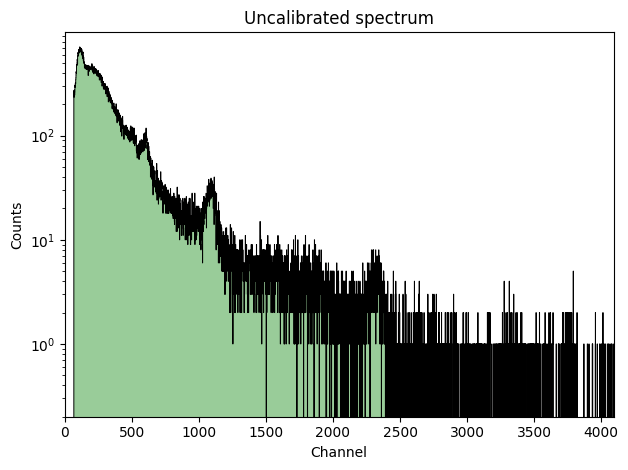

In [26]:
counts = []
filename = Path(bq.__file__).parent / "../tests/samples/SGM102432.spe"
spec = bq.Spectrum.from_file(filename)
plot_spec(spec)

[np.float64(218.5), np.float64(602.5), np.float64(1091.5), np.float64(2314.5), np.float64(3326.5), np.float64(3753.5)]
[np.float64(6.426229628545081), np.float64(18.604154116538396), np.float64(19.805237375839837), np.float64(9.739504029419468), np.float64(3.1737597920250953), np.float64(5.71579378096312)]


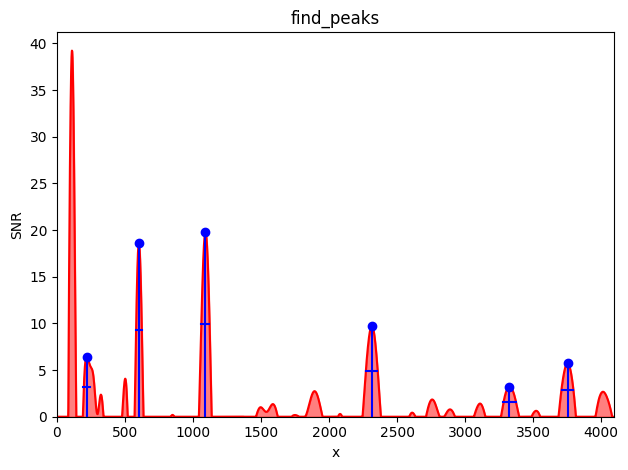

In [27]:
kernel = bq.GaussianPeakFilter(2400, 120, 30)
finder = bq.PeakFinder(spec, kernel)
cal = bq.AutoCalibrator(finder)

# find significant peaks
cal.peakfinder.find_peaks(min_snr=3, xmin=200)
print(cal.peakfinder.centroids)
print(cal.peakfinder.snrs)

plt.figure()
plt.title("find_peaks")
cal.peakfinder.plot()
plt.tight_layout()

found best gain: 0.608867 keV/channel
fit gain: 0.6088673452119725 keV/channel
fit channels: [ 602.5 1091.5 2314.5]


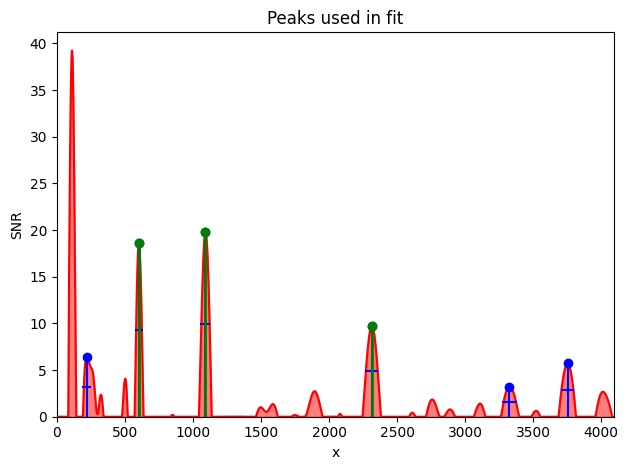

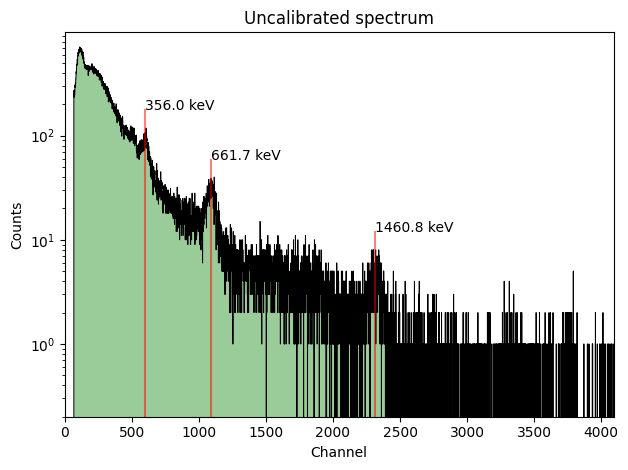

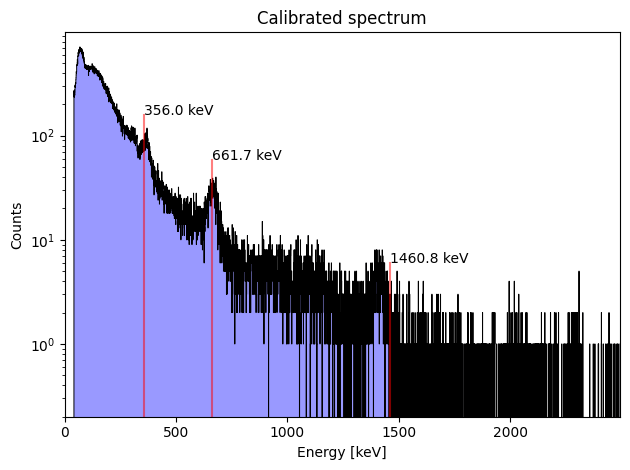

In [28]:
cal.fit(
    [356.0129, 661.657, 1460.82],
    optional=[911.20, 1120.294, 1764.49, 2614.3],
    gain_range=[0.5, 0.7],
    de_max=100.0,
)
plot_calibrator(cal)

This last plot reveals that the 1460 keV peak does not quite line up with the calibration, so this detector probably exhibits a significant nonlinearity and would have to be calibrated with a more sophisticated method.